In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif
from deepsvg.svglib.geom import Bbox
from deepsvg.svg_dataset import SVGDataset, load_dataset
from deepsvg.utils.utils import batchify, linear

import torch
import numpy as np

In [4]:
import csv

# Compute the corresponding latent vector of tree visualizations

In [5]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

Load the training model of tree visualization dataset

In [6]:
pretrained_path = "./pretrained/treevis_model.pth.tar"
from configs.deepsvg.hierarchical_ordered import Config

cfg = Config()
model = cfg.make_model().to(device)
utils.load_model(pretrained_path, model)
model.eval();

model_args ['commands', 'args', 'commands', 'args']
model.py 104 seq_len 10
model.py 34 max_len 12
model.py 116 cfg.max_num_groups 100
model.py 69 seq_len 100
model.py 69 seq_len 11


In [7]:
dataset = load_dataset(cfg)

cfg.data_dir ./dataset/svgs_simplified/ cfg.meta_filepath ./dataset/svg_meta.csv
check point1 207
filter_platform None filter_category None max_num_groups 100 max_seq_len 10 max_total_len 1000
check point3 207


In [8]:
def encode(data):
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
        return z

In [9]:
def encode_svg(svg):
    data = dataset.get(svg=svg)
    return encode(data)

In [10]:
def decode(z, do_display=True, return_svg=False, return_png=False):
    commands_y, args_y = model.greedy_sample(z=z)
    tensor_pred = SVGTensor.from_cmd_args(commands_y[0].cpu(), args_y[0].cpu())
    svg_path_sample = SVG.from_tensor(tensor_pred.data, viewbox=Bbox(256), allow_empty=True).normalize().split_paths().set_color("random")
    
    if return_svg:
        return svg_path_sample
    
    return svg_path_sample.draw(do_display=do_display, return_png=return_png)

In [11]:
def load_svg(filename):
    svg = SVG.load_svg(filename)
#     svg = dataset.simplify(svg)
#     svg = dataset.preprocess(svg)
    return svg

In [12]:
def transform_svg_to_list(svg_file_path_name):
    svg = load_svg(svg_file_path_name)
    latent_vector = encode_svg(svg)
    latent_vector_array = latent_vector.tolist()
    return latent_vector_array

In [13]:
def save_csv_file(csv_file_path_name, row_list):
    with open(csv_file_path_name,"w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(row_list)

In [40]:
svg_folder_path = "dataset/svgs_simplified"
svg_file_latent_vectors = []
with open('dataset/svg_meta.csv','rt')as f:
    svg_meta_data = csv.reader(f)
    header = next(svg_meta_data)
    for row in svg_meta_data:
        svg_file_name = row[0] + '.svg'
        svg_file_path_name = os.path.join(svg_folder_path, svg_file_name)
        latent_vector_array = transform_svg_to_list(svg_file_path_name)
        svg_file_latent_vectors.append(latent_vector_array[0][0][0])
svg_latent_vectors_path_name = 'dataset/svg_latent_vectors.csv'
save_csv_file(svg_latent_vectors_path_name, svg_file_latent_vectors)

In [28]:
svg1 = load_svg("dataset/svgs_simplified/39091.svg")
# svg1 = load_svg("docs/frames/face_1.svg")
z1 = encode_svg(svg1)
print(z1.shape)
print(z1)

torch.Size([1, 1, 1, 256])
tensor([[[[ 0.5886, -0.6213, -0.1896, -0.0170,  0.1007,  0.4125, -1.1665,
            0.3930,  0.3927,  0.3178,  0.8436,  1.0158, -1.0021,  0.2204,
           -0.2429,  0.4291, -0.8998, -0.2535,  1.0950,  0.1487,  0.2590,
           -0.3744, -0.3718,  1.2808,  0.9027,  0.0831,  0.3149,  0.2674,
           -0.7472, -0.1174,  1.2471, -0.7068, -0.8883,  0.1822, -0.1287,
            0.4255,  0.7005, -0.3089, -0.5268, -0.1876,  0.6042,  0.4260,
           -1.0234, -0.0068, -0.0603,  1.0741, -0.4883, -0.2867, -1.0255,
           -0.9236,  0.2824, -0.0753, -0.1835, -0.0692,  0.3935,  1.0110,
            0.7245, -0.5197,  0.5974, -0.0309, -0.9831,  0.4373, -0.2280,
            0.0307,  0.1831,  0.0243,  0.3461, -0.4361, -0.9731,  0.2440,
            0.9416, -0.5986, -0.5852, -0.4552, -0.6459, -0.4400,  0.1449,
            1.1343,  0.8115,  0.6357, -0.0379,  0.0782,  1.1648, -0.1236,
            0.2684, -0.3968, -0.6774,  0.3208, -0.1980,  0.5985, -0.0757,
           

In [29]:
decode(z1, do_display=False, return_svg=True)

SVG[Bbox(0.0 0.0 24.0 24.0)](
	SVGPathGroup(SVGPath(M[P(0.0, 0.0), P(12.75, 9.28125)] L[P(12.75, 9.28125), P(11.0625, 10.78125)] L[P(11.0625, 10.78125), P(11.0625, 10.78125)] Z[P(11.0625, 10.78125), P(12.75, 9.28125)])),
	SVGPathGroup(SVGPath(M[P(-0.09375, -0.09375), P(16.78125, 9.9375)] L[P(16.78125, 9.9375), P(12.5625, 10.3125)] L[P(12.5625, 10.3125), P(12.5625, 10.5)] Z[P(12.5625, 10.5), P(16.78125, 9.9375)])),
	SVGPathGroup(SVGPath(M[P(-0.09375, -0.09375), P(12.09375, 6.09375)] L[P(12.09375, 6.09375), P(12.09375, 9.65625)] L[P(12.09375, 9.65625), P(12.09375, 9.65625)] Z[P(12.09375, 9.65625), P(12.09375, 6.09375)])),
	SVGPathGroup(SVGPath(M[P(-0.09375, -0.09375), P(12.09375, 4.875)] L[P(12.09375, 4.875), P(11.53125, 9.28125)] L[P(11.53125, 9.28125), P(11.53125, 9.375)] Z[P(11.53125, 9.375), P(12.09375, 4.875)])),
	SVGPathGroup(SVGPath(M[P(-0.09375, -0.09375), P(16.78125, 9.9375)] L[P(16.78125, 9.9375), P(12.5625, 10.5)] L[P(12.5625, 10.5), P(12.5625, 10.78125)] Z[P(12.5625, 10.78125

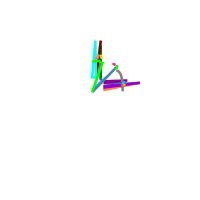

In [30]:
decode(z1, do_display=True, return_png=False)

In [20]:
l1 = z1.tolist()

In [57]:
print(l1)

[[[[-0.3945389986038208, 0.5693248510360718, 1.2302370071411133, -0.9449902772903442, 0.1305479258298874, -1.366237998008728, 0.5054230690002441, -1.2562538385391235, -0.29031097888946533, -0.0934842973947525, -1.0110340118408203, -2.1089961528778076, 0.31432801485061646, 0.31602421402931213, 1.7766863107681274, -0.9548288583755493, 0.16263708472251892, -1.1551719903945923, -0.21126098930835724, -2.127227306365967, 1.4409469366073608, 0.5741609930992126, -1.4085593223571777, -1.5041500329971313, -0.3342382311820984, 0.07823284715414047, 0.20810678601264954, -1.0631102323532104, 0.6459565758705139, 0.4559199810028076, 1.1964231729507446, -1.0823664665222168, 1.080611228942871, -2.002143383026123, -0.9242523312568665, 0.29054200649261475, -1.9453808069229126, 0.2233676314353943, 0.24732661247253418, 1.1103817224502563, 0.7288916110992432, 0.045822467654943466, -2.2712180614471436, 1.084022045135498, -0.2596467137336731, -0.7691308856010437, -0.32048091292381287, 1.1849526166915894, 0.573